**Agglomerative Clustering might be good for feature selection**

In [121]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [122]:
# import data
X_train_engineered = pd.read_pickle('data/X_train_engineered.pkl')
X_test_engineered = pd.read_pickle('data/X_test_engineered.pkl')
# X_train_engineered = pd.read_pickle('data/X_train_scaled.pkl')
# X_test_engineered = pd.read_pickle('data/X_test_scaled.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')

## Feature Selection

In [123]:
# correlation based
def select_by_correlation(X_train, y_train, threshold=0.2):
    """
    Select features based on correlation with target
    """
    corr = pd.concat([X_train, y_train], axis=1).corr()
    target_corr = corr[y_train.name].abs().sort_values(ascending=False)
    selected_features = target_corr[target_corr > threshold].index.tolist()
    selected_features.remove(y_train.name)  # Remove target from features
    return selected_features

motor_features_corr = select_by_correlation(X_train_engineered, y_train_motor)
print(f"Selected features based on correlation: {motor_features_corr}")
print(f"Number of selected features: {len(motor_features_corr)}")

Selected features based on correlation: ['age^2', 'PPE age', 'age', 'age_x_DFA', 'Jitter(%) age', 'nonlinear_std', 'age test_time', 'noise_std', 'HNR', 'noise_mean']
Number of selected features: 10


### RFE

In [124]:
# recursive feature elimination
def select_by_rfe_cv(X_train, y_train, min_features=5, step=5, cv=5):
    """
    Dynamically select features using RFE with cross-validation.
    Returns: Optimal features and best number of features.
    """
    estimator = LinearRegression()
    selector = RFECV(
        estimator, 
        min_features_to_select=min_features,  # Minimum features to consider
        step=step,                           # Features to drop each iteration
        cv=cv,                               # Cross-validation folds
        scoring='r2'                         # Metric to optimize (or 'neg_mean_absolute_error')
    )
    selector.fit(X_train, y_train)
    
    selected_features = X_train.columns[selector.support_]
    print(f"Optimal number of features: {selector.n_features_}")
    return selected_features.tolist()

motor_features_rfe_cv = select_by_rfe_cv(X_train_engineered, y_train_motor)
print(f"Selected features using RFE: {motor_features_rfe_cv}")

Optimal number of features: 5
Selected features using RFE: ['Jitter:RAP', 'Jitter:DDP', 'Shimmer:APQ3', 'Shimmer:DDA', 'age^2']


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents 

In [125]:
def select_by_rfe_dynamic(X_train, y_train, max_features=20, min_features=5, step=1, threshold=0.02):
    """
    Dynamic RFE that stops when performance drops beyond a threshold.
    """
    estimator = LinearRegression()
    scores = []
    feature_counts = range(max_features, min_features - 1, -step)
    
    for n_features in feature_counts:
        selector = RFE(estimator, n_features_to_select=n_features)
        X_selected = selector.fit_transform(X_train, y_train)
        
        # Score with cross-validation (e.g., R²)
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
        
        # Stop if score drops significantly
        if len(scores) > 1 and (scores[-2] - scores[-1]) > threshold:
            best_n = feature_counts[len(scores) - 2]  # Previous count was better
            selector = RFE(estimator, n_features_to_select=best_n).fit(X_train, y_train)
            return X_train.columns[selector.support_].tolist()
    
    # If no drop, return min_features
    selector = RFE(estimator, n_features_to_select=min_features).fit(X_train, y_train)
    return X_train.columns[selector.support_].tolist()

# Usage
motor_features_rfe = select_by_rfe_dynamic(X_train_engineered, y_train_motor)
print(f"Selected features using dynamic RFE: {motor_features_rfe}")
print(f'Optimal number of features selected: {len(motor_features_rfe)}')

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents 

Selected features using dynamic RFE: ['Jitter(Abs)', 'Jitter:RAP', 'Jitter:DDP', 'Shimmer:APQ5', 'RPDE', 'DFA', 'Shimmer(dB)', 'jitter_mean', 'jitter_std', 'shimmer_mean', 'nonlinear_mean', 'age_x_DFA', 'Jitter(%)', 'PPE', 'age', 'Jitter(%)^2', 'Jitter(%) PPE', 'Jitter(%) age', 'PPE age', 'age^2']
Optimal number of features selected: 20


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents 

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents 

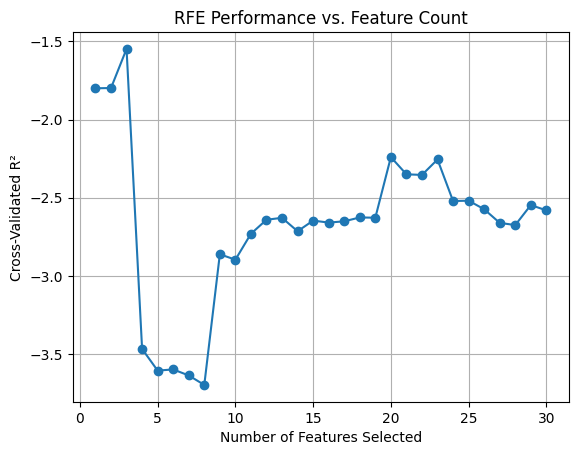

In [126]:
import matplotlib.pyplot as plt

def plot_rfe_performance(X_train, y_train, max_features=30):
    estimator = LinearRegression()
    feature_counts = range(1, max_features + 1)
    scores = []
    
    for n in feature_counts:
        selector = RFE(estimator, n_features_to_select=n)
        X_selected = selector.fit_transform(X_train, y_train)
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
    
    plt.plot(feature_counts, scores, 'o-')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validated R²")
    plt.title("RFE Performance vs. Feature Count")
    plt.grid()
    plt.show()

plot_rfe_performance(X_train_engineered, y_train_motor)

### Model based

In [127]:
# feature importance from tree based models
def select_by_feature_importance(X_train, y_train, threshold='mean'):
    """
    Select features based on importance from Random Forest
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    if threshold == 'mean':
        threshold = importances.mean()
    
    selected_features = X_train.columns[importances > threshold]
    return selected_features.tolist()

motor_features_imp = select_by_feature_importance(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance: {motor_features_imp}")
print(f'Optimal number of features selected: {len(motor_features_imp)}')

Selected features using feature importance: ['sex', 'RPDE', 'voice_instability', 'age_x_DFA', 'age', 'age^2', 'age test_time']
Optimal number of features selected: 7


In [128]:
# def select_by_feature_importance_perc(X_train, y_train, percentile=50):
#     """
#     Select top features based on importance percentile.
#     """
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train)
#     importances = model.feature_importances_
    
#     # Calculate threshold as percentile (e.g., 50th percentile = median)
#     threshold = np.percentile(importances, percentile)
#     selected_features = X_train.columns[importances >= threshold]
    
#     print(f"Threshold ({percentile}th percentile): {threshold:.4f}")
#     return selected_features.tolist()

# # Usage: Keep top 50% most important features
# motor_features_imp_perc = select_by_feature_importance(X_train_engineered, y_train_motor, percentile=50)
# print(f"Selected features using feature importance (50th percentile): {motor_features_imp_perc}")
# print(f'Optimal number of features selected: {len(motor_features_imp_perc)}')

In [129]:
# !pip install kneed

In [130]:
from kneed import KneeLocator

def select_by_importance_elbow(X_train, y_train):
    """
    Automatically find the "elbow point" in feature importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    # Sort features by importance (descending)
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    
    # Find elbow point (point of diminishing returns)
    kneedle = KneeLocator(
        range(len(sorted_importances)),
        sorted_importances,
        curve='convex',
        direction='decreasing'
    )
    optimal_idx = kneedle.elbow
    threshold = sorted_importances[optimal_idx]
    
    selected_features = X_train.columns[importances >= threshold]
    print(f"Elbow threshold: {threshold:.4f} (kept {len(selected_features)} features)")
    return selected_features.tolist()

motor_features_imp_elbow = select_by_importance_elbow(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance (elbow method): {motor_features_imp_elbow}")
print(f'Optimal number of features selected: {len(motor_features_imp_elbow)}')

Elbow threshold: 0.0321 (kept 4 features)
Selected features using feature importance (elbow method): ['age_x_DFA', 'age', 'age^2', 'age test_time']
Optimal number of features selected: 4


In [131]:
from sklearn.inspection import permutation_importance

def select_by_permutation_importance(X_train, y_train, n_repeats=10, threshold=0.01):
    """
    Select features with statistically significant importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Compute permutation importance
    result = permutation_importance(
        model, X_train, y_train, n_repeats=n_repeats, random_state=42
    )
    importances = result.importances_mean
    
    # Select features where importance > threshold
    selected_features = X_train.columns[importances > threshold]
    print(f"Features with permutation importance > {threshold}: {len(selected_features)}")
    return selected_features.tolist()

motor_features_imp_perm = select_by_permutation_importance(X_train_engineered, y_train_motor)
print(f"Selected features using permutation importance: {motor_features_imp_perm}")
print(f'Optimal number of features selected: {len(motor_features_imp_perm)}')

Features with permutation importance > 0.01: 12
Selected features using permutation importance: ['sex', 'Jitter(Abs)', 'RPDE', 'DFA', 'noise_mean', 'voice_instability', 'age_x_DFA', 'age', 'test_time', 'age^2', 'age test_time', 'test_time^2']
Optimal number of features selected: 12


### Mutual information

In [132]:
# mutual information
def select_by_mutual_info(X_train, y_train, n_features=10):
    """
    Select features based on mutual information
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    selected_features = mi_series.sort_values(ascending=False).head(n_features).index
    return selected_features.tolist()

motor_features_mi = select_by_mutual_info(X_train_engineered, y_train_motor)
print(f"Selected features using mutual information: {motor_features_mi}")
print(f'Optimal number of features selected: {len(motor_features_mi)}')

Selected features using mutual information: ['test_time', 'test_time^2', 'age test_time', 'age', 'age^2', 'age_x_DFA', 'sex', 'PPE age', 'Jitter(%) age', 'PPE test_time']
Optimal number of features selected: 10


In [133]:
def select_by_mi_percentile(X_train, y_train, percentile=50):
    """
    Select features with MI in the top percentile (default: top 50%).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    # Calculate threshold
    threshold = np.percentile(mi, percentile)
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

# Keep top 25% of features
motor_features_mi_perc = select_by_mi_percentile(X_train_engineered, y_train_motor, percentile=75)
print(f"Selected features using mutual information (75th percentile): {motor_features_mi_perc}")
print(f'Optimal number of features selected: {len(motor_features_mi_perc)}')

Selected 11 features (MI ≥ 0.2186)
Selected features using mutual information (75th percentile): ['sex', 'age_x_DFA', 'age', 'test_time', 'Jitter(%) age', 'Jitter(%) test_time', 'PPE age', 'PPE test_time', 'age^2', 'age test_time', 'test_time^2']
Optimal number of features selected: 11


In [134]:
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.utils import shuffle

# def select_by_mi_significance(X_train, y_train, alpha=0.05, n_permutations=100):
#     """
#     Select features with MI significantly > 0 (via permutation test).
#     """
#     # Compute true MI
#     mi_true = mutual_info_regression(X_train, y_train)
    
#     # Null distribution (shuffled y)
#     mi_null = np.zeros((n_permutations, X_train.shape[1]))
#     for i in range(n_permutations):
#         y_shuffled = shuffle(y_train)
#         mi_null[i, :] = mutual_info_regression(X_train, y_shuffled)
    
#     # Significance threshold (95th percentile of null)
#     threshold = np.percentile(mi_null, 100 * (1 - alpha))
#     significant_features = X_train.columns[mi_true > threshold].tolist()
    
#     print(f"Selected {len(significant_features)} features (p < {alpha})")
#     return significant_features

# motor_features_mi_perm = select_by_mi_significance(X_train_engineered, y_train_motor)
# print(f"Selected features using mutual information (significance test): {motor_features_mi_perm}")
# print(f'Optimal number of features selected: {len(motor_features_mi_perm)}')

In [135]:
# from kneed import KneeLocator

# def select_by_mi_elbow(X_train, y_train):
#     """
#     Select features using the elbow point in sorted MI values.
#     """
#     mi = mutual_info_regression(X_train, y_train)
#     mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
    
#     # Find elbow point
#     kneedle = KneeLocator(
#         range(len(mi_series)),
#         mi_series.values,
#         curve='convex',
#         direction='decreasing'
#     )
#     optimal_n = kneedle.elbow
#     selected_features = mi_series.index[:optimal_n].tolist()
    
#     print(f"Selected {optimal_n} features (elbow threshold: {mi_series[optimal_n]:.4f})")
#     return selected_features

# motor_features_mi_elbow = select_by_mi_elbow(X_train_engineered, y_train_motor)
# print(f"Selected features using mutual information (elbow method): {motor_features_mi_elbow}")
# print(f'Optimal number of features selected: {len(motor_features_mi_elbow)}')

In [136]:
def select_by_mi_adaptive(X_train, y_train, k=1.0):
    """
    Select features with MI > mean + k * std (default: k=1).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    threshold = mi_series.mean() + k * mi_series.std()
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

# More aggressive (k=1.5) or lenient (k=0.5)
motor_features_mi_adapt = select_by_mi_adaptive(X_train_engineered, y_train_motor, k=0.5)
print(f"Selected features using mutual information (adaptive threshold): {motor_features_mi_adapt}")
print(f'Optimal number of features selected: {len(motor_features_mi_adapt)}')

Selected 5 features (MI ≥ 1.5132)
Selected features using mutual information (adaptive threshold): ['age', 'test_time', 'age^2', 'age test_time', 'test_time^2']
Optimal number of features selected: 5


### Clustering

In [137]:
# agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

def select_by_agglomerative_clustering(X_train, n_clusters=5):
    """
    Select features using Agglomerative Clustering
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X_train.T)
    clusters = pd.Series(clustering.labels_, index=X_train.columns)
    
    selected_features = []
    for cluster in clusters.unique():
        cluster_features = clusters[clusters == cluster].index.tolist()
        selected_features.append(cluster_features[0])  # Select one feature from each cluster
    
    return selected_features

motor_features_agglom = select_by_agglomerative_clustering(X_train_engineered, n_clusters=5)
print(f"Selected features using Agglomerative Clustering: {motor_features_agglom}")

Selected features using Agglomerative Clustering: ['sex', 'Jitter(Abs)', 'Shimmer', 'age_x_DFA', 'test_time']


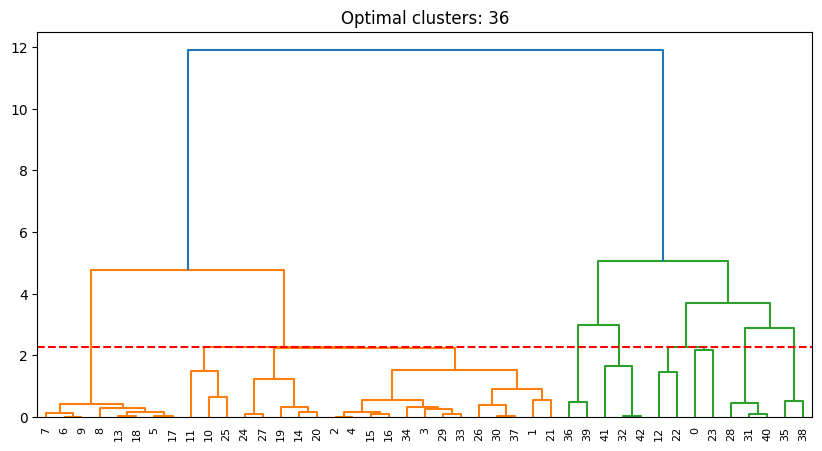

In [138]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def find_optimal_clusters(feature_corr, max_clusters=10):
    """
    Find optimal cluster count using the elbow method on linkage distances.
    """
    Z = linkage(feature_corr, method='ward')
    
    # Calculate distances between merges
    distances = Z[:, 2]
    x = range(1, len(distances)+1)
    
    # Find elbow point
    kn = KneeLocator(x, distances, curve='convex', direction='increasing')
    optimal_clusters = kn.elbow or max_clusters  # Fallback to max_clusters
    
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.axhline(y=distances[optimal_clusters-1], color='r', linestyle='--')
    plt.title(f"Optimal clusters: {optimal_clusters}")
    plt.show()
    
    return optimal_clusters

feature_corr = X_train_engineered.corr().abs().values  # Absolute correlation matrix
optimal_clusters = find_optimal_clusters(feature_corr)

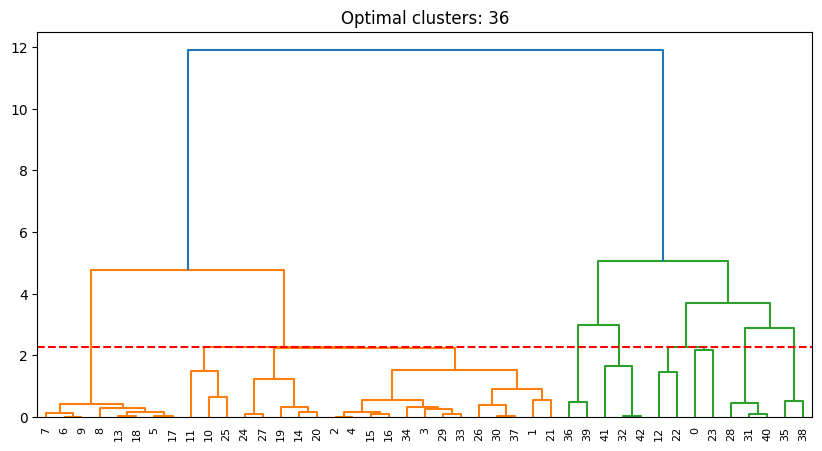

Selected features: ['age_x_DFA', 'PPE test_time', 'PPE age', 'nonlinear_mean', 'PPE', 'Jitter(%)', 'Shimmer(dB)', 'RPDE', 'Jitter(%) test_time', 'jitter_std', 'sex', 'Jitter:PPQ5', 'NHR', 'noise_std', 'age test_time', 'Jitter(%) PPE', 'Jitter:RAP', 'jitter_mean_x_shimmer_mean', 'age^2', 'Jitter(Abs)', 'age', 'Shimmer', 'Jitter(%)_x_Shimmer', 'Shimmer:APQ3', 'noise_mean', 'test_time', 'NHR_x_HNR', 'voice_instability', 'RPDE_x_PPE', 'Shimmer:APQ11', 'nonlinear_std', 'Shimmer:APQ5', 'HNR', 'Jitter(%) age', 'DFA', 'jitter_mean']


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [139]:
def select_from_clusters(X_train, n_clusters=None):
    """
    Select representative features from clusters using correlation analysis.
    """
    corr_matrix = X_train.corr().abs()
    
    # Auto-determine clusters if not specified
    if n_clusters is None:
        n_clusters = find_optimal_clusters(corr_matrix.values)
    
    # Cluster features
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        # affinity='precomputed', 
        linkage='complete'
    )
    clusters = clustering.fit_predict(1 - corr_matrix)  # Convert similarity to distance
    
    selected_features = []
    for cluster_id in np.unique(clusters):
        cluster_features = corr_matrix.columns[clusters == cluster_id]
        
        # Strategy 1: Select feature with highest average correlation to others in cluster
        rep_feature = corr_matrix.loc[cluster_features, cluster_features].mean().idxmax()
        selected_features.append(rep_feature)
        
        # Strategy 2: Add secondary features with correlation < threshold
        secondary_features = [
            f for f in cluster_features 
            if corr_matrix.loc[f, rep_feature] < 0.7  # Anti-correlation threshold
        ]
        selected_features.extend(secondary_features[:2])  # Keep at most 2 extras
    
    return list(set(selected_features))  # Remove duplicates

# Usage
motor_features_agglom_dynamic = select_from_clusters(X_train_engineered)
print(f"Selected features: {motor_features_agglom_dynamic}")

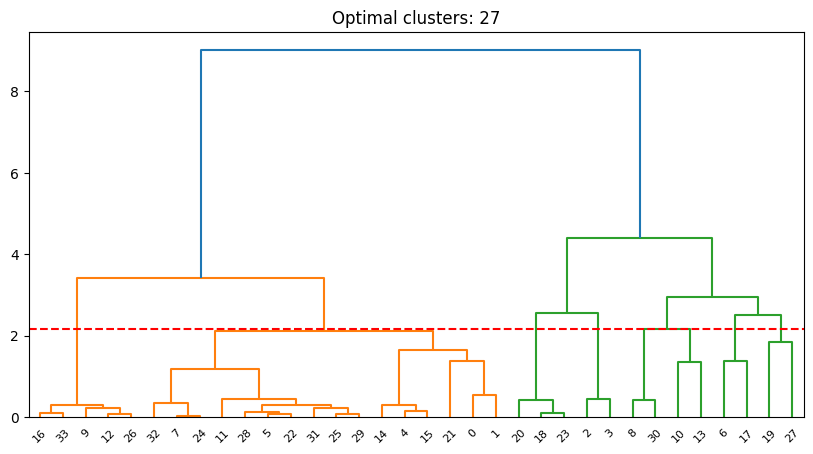

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


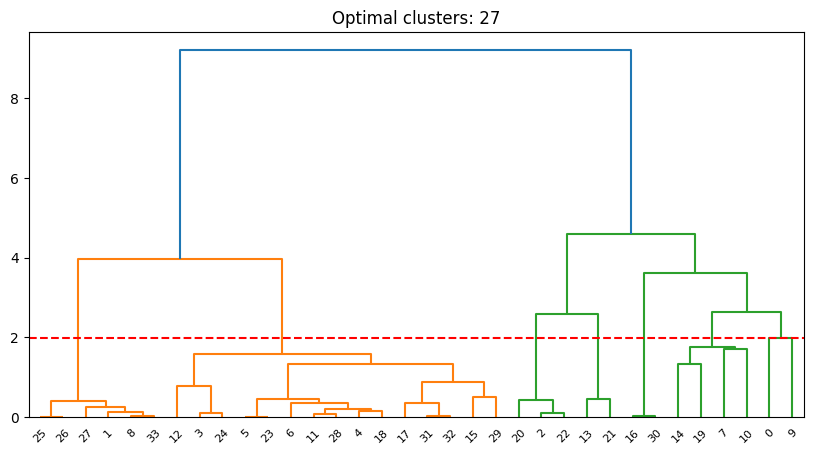

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


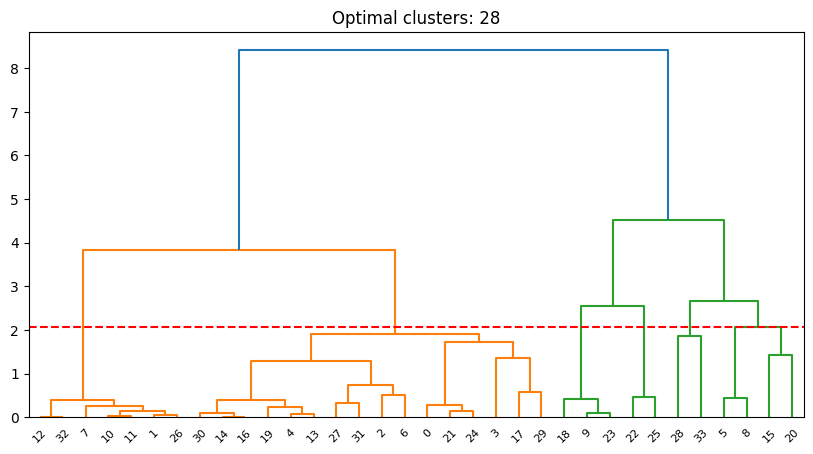

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


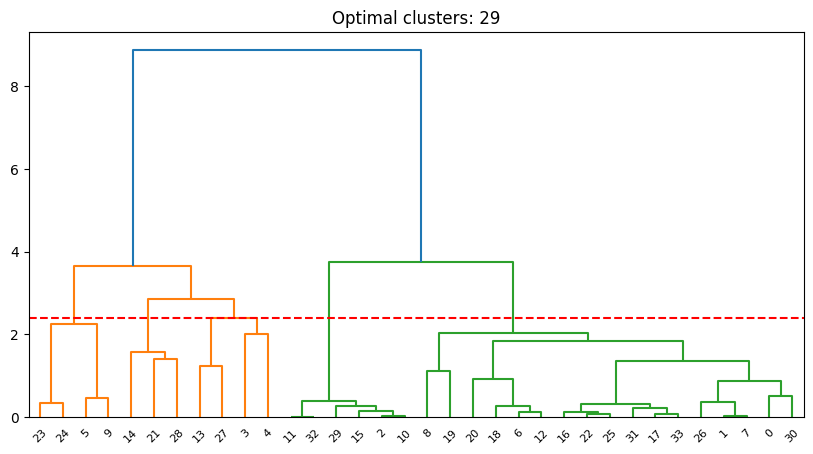

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


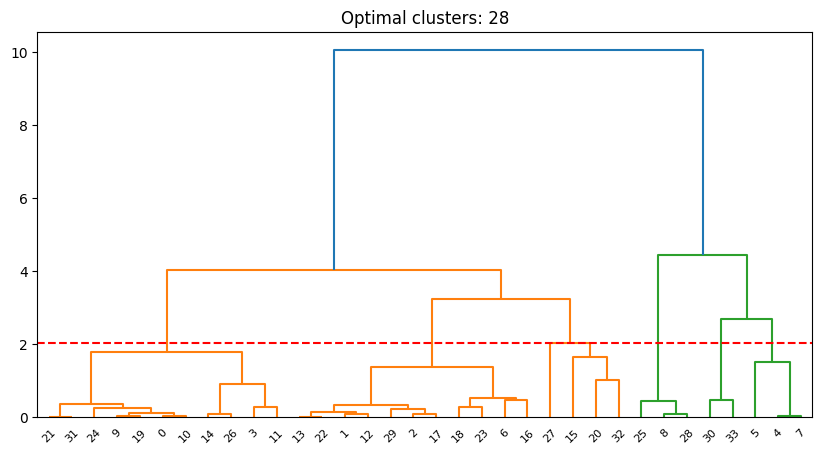

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


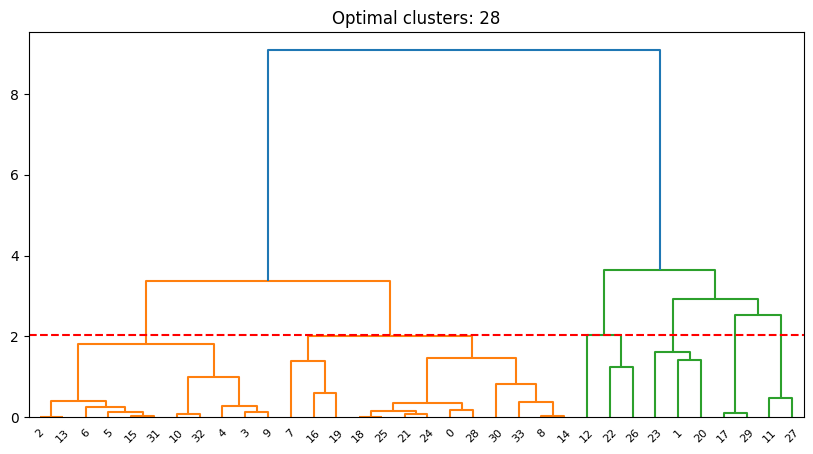

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


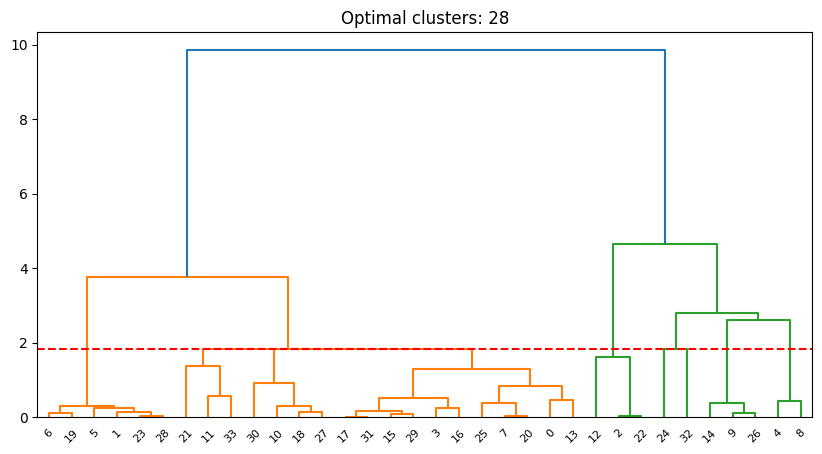

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


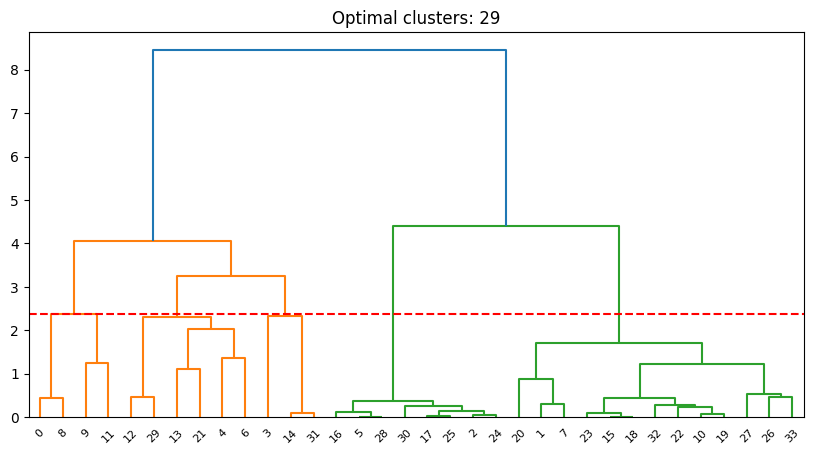

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


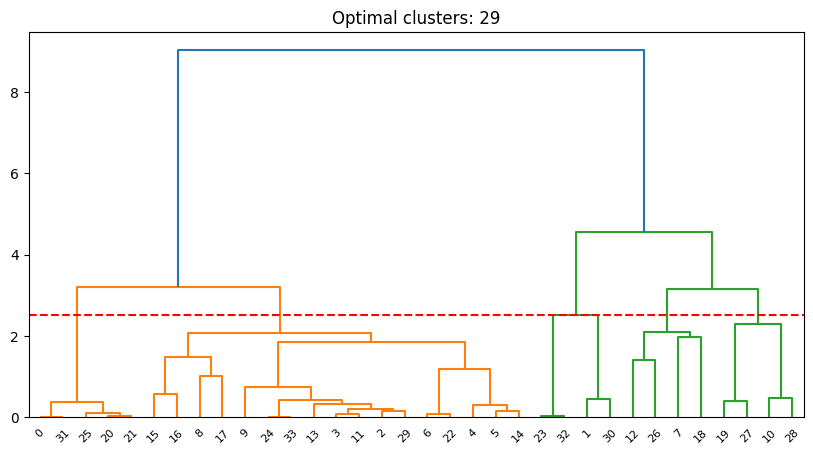

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


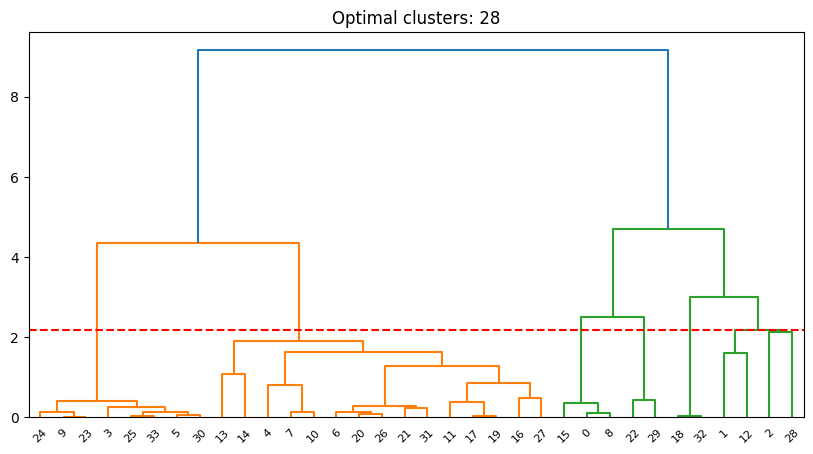

Stable features across iterations: ['RPDE', 'Jitter(%) age', 'Shimmer:APQ11', 'noise_std', 'PPE age', 'nonlinear_mean', 'nonlinear_std', 'Jitter:PPQ5', 'RPDE_x_PPE', 'NHR_x_HNR', 'age', 'DFA', 'HNR', 'noise_mean', 'age_x_DFA', 'Jitter:DDP', 'Jitter(%) test_time', 'jitter_mean_x_shimmer_mean', 'age^2', 'jitter_mean', 'voice_instability', 'sex', 'Jitter(%)^2', 'Jitter(Abs)', 'PPE test_time', 'Shimmer:DDA', 'age test_time', 'Jitter(%)', 'Shimmer', 'test_time', 'test_time^2', 'Jitter(%) PPE', 'PPE', 'NHR', 'shimmer_std']
Optimal number of features selected: 35


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [140]:
def stable_feature_selection(X_train, n_iter=10):
    """Select features that consistently appear in clusters across iterations."""
    all_selected = []
    for _ in range(n_iter):
        # Subsample data
        X_sample = X_train.sample(frac=0.8, axis=1)  # Columns (features)
        features = select_from_clusters(X_sample)
        all_selected.extend(features)
    
    # Count feature occurrences
    feature_counts = pd.Series(all_selected).value_counts()
    stable_features = feature_counts[feature_counts >= n_iter//2].index.tolist()
    
    return stable_features

stable_features = stable_feature_selection(X_train_engineered)
print(f"Stable features across iterations: {stable_features}")
print(f'Optimal number of features selected: {len(stable_features)}')

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/sk/d9tjm4zn4bdgj4c6yq745dy00000gn/T/ipykernel_20661/763002067.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage=linkage(1 - corr.abs().values, method='complete'),
/var/folders/sk/d9tjm4zn4bdgj4c6yq745dy00000gn/T/ipykernel_20661/763002067.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage=linkage(1 - corr.abs().values, method='complete'),


Cluster 0: test_time, Jitter(%) test_time, PPE test_time, age test_time, test_time^2
Cluster 1: sex, DFA, nonlinear_std, voice_instability
Cluster 2: age_x_DFA, age, Jitter(%) age, PPE age, age^2
Cluster 3: Shimmer, Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA, Shimmer(dB), shimmer_mean, shimmer_std
Cluster 4: Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP, NHR, RPDE, HNR, jitter_mean, jitter_std, noise_mean, noise_std, nonlinear_mean, Jitter(%)_x_Shimmer, NHR_x_HNR, RPDE_x_PPE, jitter_mean_x_shimmer_mean, Jitter(%), PPE, Jitter(%)^2, Jitter(%) PPE, PPE^2


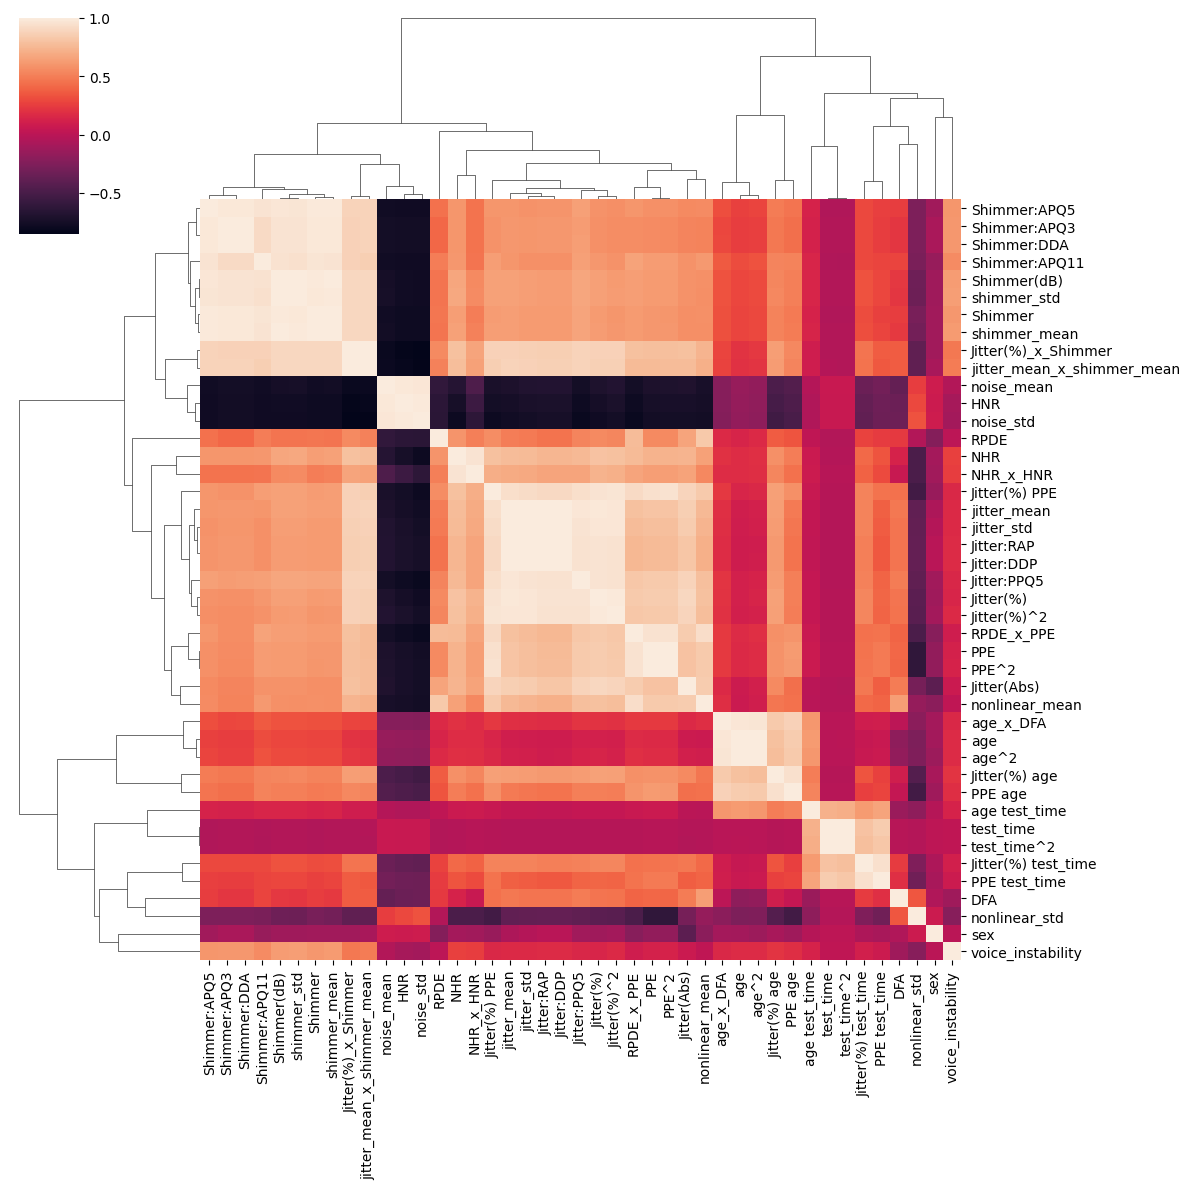

In [141]:
import seaborn as sns

def plot_clustered_corr(X, clusters):
    """Plot correlation matrix with cluster annotations."""
    corr = X.corr()
    sns.clustermap(
        corr, 
        row_linkage=linkage(1 - corr.abs().values, method='complete'),
        col_linkage=linkage(1 - corr.abs().values, method='complete'),
        figsize=(12, 12)
    )
    
    # Add cluster labels
    for i, cluster_id in enumerate(np.unique(clusters)):
        features = corr.columns[clusters == cluster_id]
        print(f"Cluster {cluster_id}: {', '.join(features)}")

# Usage
clusters = AgglomerativeClustering(n_clusters=5).fit_predict(1 - X_train_engineered.corr().abs())
plot_clustered_corr(X_train_engineered, clusters)

# Compare performance 

In [142]:
from sklearn.linear_model import Lasso, Ridge
# compare the performance of different feature selection methods
def compare_feature_selection_methods(X_train, y_train, methods):
    """
    Compare different feature selection methods based on model performance.
    """
    results = {}
    
    for method in methods:
        if method == 'correlation':
            selected_features = motor_features_corr
        elif method == 'rfecv':
            selected_features = motor_features_rfe_cv
        elif method == 'rfe':
            selected_features = motor_features_rfe
        elif method == 'importance':
            selected_features = motor_features_imp
        # elif method == 'importance_perc':
        #     selected_features = select_by_feature_importance_perc(X_train, y_train, percentile=50)
        elif method == 'importance_elbow':
            selected_features = motor_features_imp_elbow
        elif method == 'importance_perm':
            selected_features = motor_features_imp_perm
        elif method == 'mutual_info':
            selected_features = motor_features_mi
        elif method == 'mutual_info_perc':
            selected_features = motor_features_mi_perc
        # elif method == 'mutual_info_significance':
        #     selected_features = motor_features_mi_perm
        elif method == 'mutual_info_adaptive':
            selected_features = motor_features_mi_adapt
        # elif method == 'mutual_info_elbow':
        #     selected_features = select_by_mi_elbow(X_train, y_train)
        elif method == 'agglomerative':
            selected_features = motor_features_agglom
        elif method == 'agglomerative_dynamic':
            selected_features = motor_features_agglom_dynamic
        elif method == 'agglomerative_stable':
            selected_features = stable_features
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Train model and evaluate performance
        model = Ridge()
        score = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='r2').mean()
        results[method] = score
    
    return results

methods = ['correlation', 'rfecv', 'rfe', 'importance', 
          'importance_elbow', 'importance_perm', 'mutual_info', 
          'mutual_info_perc', 'mutual_info_adaptive', 
          'agglomerative', 'agglomerative_dynamic', 'agglomerative_stable']
results = compare_feature_selection_methods(X_train_engineered, y_train_motor, methods)

print("Feature Selection Method Performance R^2:")
for method, score in results.items():
    print(f"{method}: {score:.4f}")

print()
print(f"Best method: {max(results, key=results.get)}")
print(f"Best R^2 score: {results[max(results, key=results.get)]:.4f}")

Feature Selection Method Performance R^2:
correlation: -1.9132
rfecv: -1.6699
rfe: -1.6040
importance: -2.0310
importance_elbow: -1.8558
importance_perm: -1.6943
mutual_info: -1.8856
mutual_info_perc: -1.8932
mutual_info_adaptive: -1.7871
agglomerative: -1.9082
agglomerative_dynamic: -1.6725
agglomerative_stable: -1.6532

Best method: rfe
Best R^2 score: -1.6040


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/lin

## Results

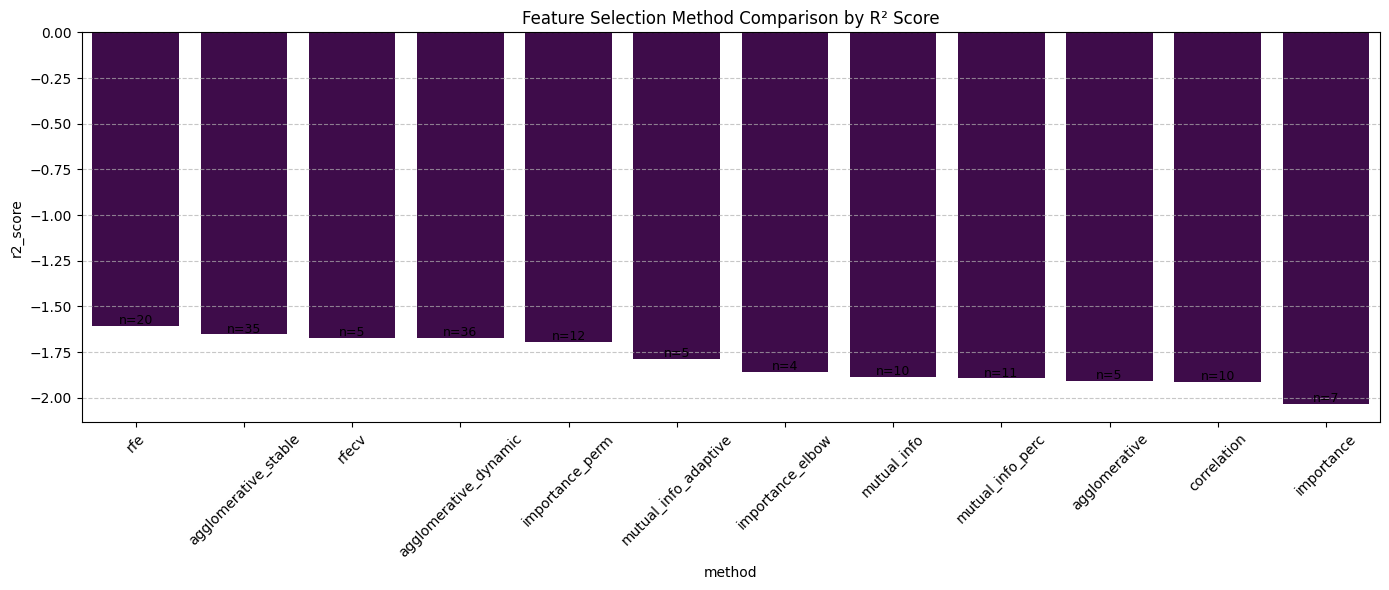

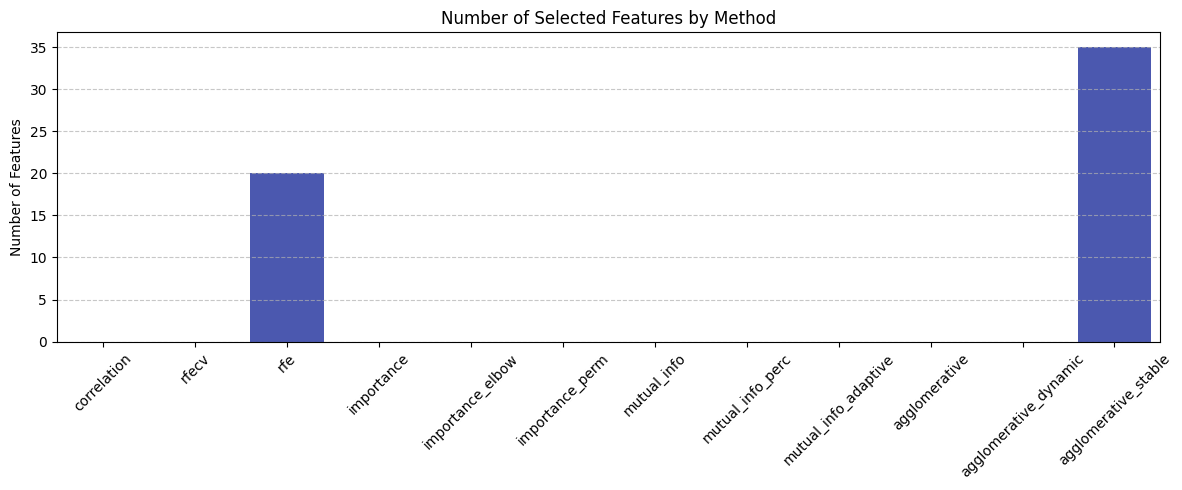

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results dictionary to DataFrame for better visualization
def plot_feature_selection_results(results_dict):
    """
    Plot comparison of feature selection methods based on R² scores
    """
    # Convert dictionary to DataFrame
    results_df = pd.DataFrame({
        'method': list(results_dict.keys()),
        'r2_score': list(results_dict.values())
    })
    
    # Sort by score (descending)
    results_df = results_df.sort_values('r2_score', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=results_df, x='method', y='r2_score', palette='viridis', hue=0.3, legend=False)
    
    # Add feature counts
    for i, method in enumerate(results_df['method']):
        if method == 'correlation':
            feature_count = len(motor_features_corr)
        elif method == 'rfecv':
            feature_count = len(motor_features_rfe_cv)
        elif method == 'rfe':
            feature_count = len(motor_features_rfe)
        elif method == 'importance':
            feature_count = len(motor_features_imp)
        elif method == 'importance_elbow':
            feature_count = len(motor_features_imp_elbow)
        elif method == 'importance_perm':
            feature_count = len(motor_features_imp_perm)
        elif method == 'mutual_info':
            feature_count = len(motor_features_mi)
        elif method == 'mutual_info_perc':
            feature_count = len(motor_features_mi_perc)
        elif method == 'mutual_info_adaptive':
            feature_count = len(motor_features_mi_adapt)
        elif method == 'agglomerative':
            feature_count = len(motor_features_agglom)
        elif method == 'agglomerative_dynamic':
            feature_count = len(motor_features_agglom_dynamic)
        elif method == 'agglomerative_stable':
            feature_count = len(stable_features)
        else:
            feature_count = 0
            
        ax.text(i, results_df['r2_score'].iloc[i] + 0.01, f"n={feature_count}", 
                ha='center', fontsize=9, color='black')
    
    plt.title('Feature Selection Method Comparison by R² Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Return feature counts for additional analysis
    return {method: len(globals().get(f"motor_features_{method.replace('_', '_')}" 
                                    if not method.startswith('agglomerative_stable') 
                                    else 'stable_features', [])) 
            for method in results_dict.keys()}

# Plot R² score comparison
feature_counts = plot_feature_selection_results(results)

# Plot feature counts separately
methods = list(feature_counts.keys())
counts = list(feature_counts.values())

plt.figure(figsize=(12, 5))
sns.barplot(x=methods, y=counts, palette='coolwarm', hue=0.6, legend=False)
plt.title('Number of Selected Features by Method')
plt.xticks(rotation=45)
plt.ylabel('Number of Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Statistically significant tests

In [144]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

def compare_methods(results_dict, method1, method2):
    """
    Simple comparison between two methods from results dictionary
    """
    score1 = results_dict[method1]
    score2 = results_dict[method2]
    
    print(f"Comparison: {method1} vs {method2}")
    print(f"R² scores:")
    print(f"{method1}: {score1:.4f}")
    print(f"{method2}: {score2:.4f}")
    print(f"Difference: {score1 - score2:.4f}")
    print("\n")

def bootstrap_test_significance(X_train, y_train, method1, method2, n_iterations=30):
    """
    Use bootstrapping to test if the difference between methods is significant
    """
    # Get feature lists for each method
    if method1 == 'correlation':
        features1 = motor_features_corr
    elif method1 == 'rfecv':
        features1 = motor_features_rfe_cv
    elif method1 == 'rfe':
        features1 = motor_features_rfe
    elif method1 == 'importance':
        features1 = motor_features_imp
    elif method1 == 'importance_elbow':
        features1 = motor_features_imp_elbow
    elif method1 == 'importance_perm':
        features1 = motor_features_imp_perm
    elif method1 == 'mutual_info':
        features1 = motor_features_mi
    elif method1 == 'mutual_info_perc':
        features1 = motor_features_mi_perc
    elif method1 == 'mutual_info_adaptive':
        features1 = motor_features_mi_adapt
    elif method1 == 'agglomerative':
        features1 = motor_features_agglom
    elif method1 == 'agglomerative_dynamic':
        features1 = motor_features_agglom_dynamic
    elif method1 == 'agglomerative_stable':
        features1 = stable_features
    else:
        raise ValueError(f"Unknown method: {method1}")
        
    if method2 == 'correlation':
        features2 = motor_features_corr
    elif method2 == 'rfecv':
        features2 = motor_features_rfe_cv
    elif method2 == 'rfe':
        features2 = motor_features_rfe
    elif method2 == 'importance':
        features2 = motor_features_imp
    elif method2 == 'importance_elbow':
        features2 = motor_features_imp_elbow
    elif method2 == 'importance_perm':
        features2 = motor_features_imp_perm
    elif method2 == 'mutual_info':
        features2 = motor_features_mi
    elif method2 == 'mutual_info_perc':
        features2 = motor_features_mi_perc
    elif method2 == 'mutual_info_adaptive':
        features2 = motor_features_mi_adapt
    elif method2 == 'agglomerative':
        features2 = motor_features_agglom
    elif method2 == 'agglomerative_dynamic':
        features2 = motor_features_agglom_dynamic
    elif method2 == 'agglomerative_stable':
        features2 = stable_features
    else:
        raise ValueError(f"Unknown method: {method2}")
    
    # Initialize arrays to store scores
    scores1 = []
    scores2 = []
    
    # Create bootstrap samples
    rs = ShuffleSplit(n_splits=n_iterations, test_size=0.3, random_state=42)
    
    # For each bootstrap iteration
    for train_idx, test_idx in rs.split(X_train):
        X_train_boot, X_test_boot = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_boot, y_test_boot = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Train and evaluate model with features from method 1
        model1 = Ridge()
        model1.fit(X_train_boot[features1], y_train_boot)
        score1 = model1.score(X_test_boot[features1], y_test_boot)
        scores1.append(score1)
        
        # Train and evaluate model with features from method 2
        model2 = Ridge()
        model2.fit(X_train_boot[features2], y_train_boot)
        score2 = model2.score(X_test_boot[features2], y_test_boot)
        scores2.append(score2)
    
    # Convert to arrays
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)
    
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(scores1, scores2)
    
    print(f"Bootstrap Comparison: {method1} vs {method2}")
    print(f"Mean R² scores:")
    print(f"{method1}: {scores1.mean():.4f} (± {scores1.std():.4f})")
    print(f"{method2}: {scores2.mean():.4f} (± {scores2.std():.4f})")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Difference is statistically significant (p < 0.05)")
    else:
        print("Difference is not statistically significant")
    print("\n")
    
    return scores1, scores2

# Example direct comparison from results dict
compare_methods(results, 'agglomerative_stable', 'rfe')

Comparison: agglomerative_stable vs rfe
R² scores:
agglomerative_stable: -1.6532
rfe: -1.6040
Difference: -0.0492




# Final selection

In [145]:
# select the best feature selection method based on the results
best_method = max(results, key=results.get)
print(f"Best feature selection method: {best_method}")

Best feature selection method: rfe


In [146]:
# apply to the dataset
X_train_final = X_train_engineered[motor_features_agglom_dynamic] 
X_test_final = X_test_engineered[motor_features_agglom_dynamic] 

In [147]:
X_train_final.columns

Index(['age_x_DFA', 'PPE test_time', 'PPE age', 'nonlinear_mean', 'PPE',
       'Jitter(%)', 'Shimmer(dB)', 'RPDE', 'Jitter(%) test_time', 'jitter_std',
       'sex', 'Jitter:PPQ5', 'NHR', 'noise_std', 'age test_time',
       'Jitter(%) PPE', 'Jitter:RAP', 'jitter_mean_x_shimmer_mean', 'age^2',
       'Jitter(Abs)', 'age', 'Shimmer', 'Jitter(%)_x_Shimmer', 'Shimmer:APQ3',
       'noise_mean', 'test_time', 'NHR_x_HNR', 'voice_instability',
       'RPDE_x_PPE', 'Shimmer:APQ11', 'nonlinear_std', 'Shimmer:APQ5', 'HNR',
       'Jitter(%) age', 'DFA', 'jitter_mean'],
      dtype='object')

In [148]:
X_train_final.head()

,age_x_DFA,PPE test_time,PPE age,nonlinear_mean,PPE,Jitter(%),Shimmer(dB),RPDE,Jitter(%) test_time,jitter_std,...,NHR_x_HNR,voice_instability,RPDE_x_PPE,Shimmer:APQ11,nonlinear_std,Shimmer:APQ5,HNR,Jitter(%) age,DFA,jitter_mean
0,0.472768,-1.763549,0.285638,-1.372076,-0.538279,0.777495,-0.095315,-1.123666,-1.648799,1.199753,...,-0.357255,-0.554521,-0.840932,-0.533430,-1.011534,-0.300446,-0.221844,1.168088,-1.562201,1.044180
1,0.547098,-1.692731,-0.276526,-1.478360,-1.370818,-0.998308,-0.601019,-0.974415,-1.634839,-1.018690,...,-0.274487,0.495168,-1.360881,-0.502414,-0.079144,-0.665638,1.287371,-0.073979,-1.289431,-1.015749
2,0.452927,-1.322724,0.753065,-0.893737,0.149463,0.037858,-0.579253,-0.717585,-1.329025,-0.086608,...,0.398075,-0.931225,-0.172123,-0.778365,-1.535420,-1.063301,0.151288,0.634197,-1.636111,-0.121687
3,0.607078,-0.798672,1.659128,0.054789,1.472585,0.254467,0.634747,-0.478170,-1.121188,-0.137827,...,1.140874,0.699946,0.919554,-0.205026,-2.496431,-0.364809,0.528789,0.787628,-1.073931,-0.056041
4,0.530947,-1.024941,0.606057,-0.838986,-0.066418,-0.769776,-0.633987,-0.625753,-1.231325,-1.229235,...,-0.284199,0.014250,-0.291019,-0.357456,-1.148857,-0.909364,0.991525,0.079011,-1.348157,-1.298858


In [149]:

X_train_final.to_pickle('data/X_train_final.pkl')
X_test_final.to_pickle('data/X_test_final.pkl')